In [1]:
import torch
import torch.nn.functional as F
import random

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# read all the names into a list of words
words = open('../data/names.txt', 'r').read().splitlines()
words[:8], len(words)

(['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'],
 32033)

In [6]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos), itos[5], itos[26]

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


(None, 'e', 'z')

In [37]:
block_size = 3 # context length: how many characters do we take to predict the next one?
# X is input -- seq of letters; Y is output -- predicted letter
X, Y = [], []
for w in words[:5]:    
    print(w)
    context = [0] * block_size # start with padded context of just zero tokens
    # print(context)
    for char in w + '.':
        ix = stoi[char]
        X.append(context)
        Y.append(ix)
        # print(ix)
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop context and append
        # print(context)
# X,Y

emma
olivia
ava
isabella
sophia


In [91]:
X = torch.tensor(X)
Y = torch.tensor(Y)
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [18]:

# Embedding Lookup Table -- C
# similar to transformer embedding layer

C = torch.randn((27, 2))
C[5]

tensor([-1.6876, -0.4172])

In [92]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-0.4713,  0.7868])

In [93]:
X.shape

torch.Size([32, 3])

In [26]:
X[13,2]

tensor(1)

In [30]:
# C shape is [27,2] ; X shape is 32, 3
# C[X] means for each element in X lookup it in C 
# -- so final matrix is [32, 3, 2] 
# -- last 2 is from each row in C
C[X].shape, X.shape

(torch.Size([32, 3, 2]), torch.Size([32, 3]))

In [34]:
C[X][13, 2]

tensor([-1.8472,  0.3231])

In [36]:
#emb is actually a list of each training data point's embedding
# 32 training data points, 3 seq length, 2 dimensions
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [38]:

# Hidden Layer + torch.Tensor Internals
# hidden layer width is 100 -- 100 neurons

W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [39]:
# unroll 3 in [32, 3, 2]
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape

torch.Size([32, 6])

In [41]:
torch.cat(torch.unbind(emb, 1), 1).shape # independent of block size

torch.Size([32, 6])

In [50]:
#torch.unbind(emb, 0)
emb.view(emb.shape[0], 6) == torch.cat(torch.unbind(emb, 1), 1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [52]:
(emb.view(-1, 6) @ W1).shape, b1.shape

(torch.Size([32, 100]), torch.Size([100]))

In [55]:
(emb.view(-1, 6) @ W1).shape

torch.Size([32, 100])

In [57]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h.shape


torch.Size([32, 100])

In [58]:
b1.shape

torch.Size([100])

In [59]:
#
# output layer
#

In [60]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)


In [61]:
logits = h @ W2 + b2

In [62]:
#
#Negative Log Likelihood Loss
#

In [64]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)
prob[0].sum()

tensor(1.0000)

In [90]:
(Y)
torch.arange(32)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [67]:
prob[torch.arange(32), Y]

tensor([2.3993e-13, 4.1572e-05, 7.6733e-01, 1.3057e-01, 1.0494e-06, 2.8868e-09,
        1.1623e-06, 2.8073e-07, 3.4864e-09, 2.6760e-13, 8.9014e-14, 1.2230e-08,
        2.5588e-13, 1.1859e-02, 1.2698e-14, 2.8543e-14, 9.1649e-07, 2.0094e-09,
        1.5945e-18, 4.8491e-12, 2.2635e-07, 9.0926e-13, 4.4778e-08, 7.9674e-04,
        8.3802e-08, 1.6255e-08, 2.0263e-09, 1.7961e-05, 1.8982e-13, 5.2459e-12,
        1.5880e-13, 7.6131e-09])

In [68]:
prob[torch.arange(32), Y].log().mean()

tensor(-19.7995)

In [73]:
# n: 3 (block_size)
# m: 2 lower-dimensional space (arbitrary choice)
# V: 27 characters (26 alphabets + . character)
# C: 27  2 (vocabulary size  m) === embedding
# input layer: 6 nodes - 3  2 (number of input characters  m)
# W1: 6  100 (input features  number of neurons in next (hidden) layer)
# b1: 100 hidden layer elements
# hidden layer: 100 (100 neurons is a hyperparameter we chose to start with)
# W2: 100  27 (number of neurons in previous (hidden) layer  number of neurons in next (output) layer)
# b2: 27 output layer elements
# output layer: 27 neurons
# The number of free parameters (excluding W3): (27 * 2) + (6 * 100) + (100 * 27) + 100 + 27
# Using the general parameters' equation above (excluding the use of W3): 27*(1 + (1)*2 + 100) + 100*(1 + 3*2)
# Both ways should give the same answer of 3481

In [80]:
# ------------------- MLP Implementation ---------------------------------
g = torch.Generator().manual_seed(2147483647)     # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [81]:
par_count = 0
for par in parameters:
    if len(par.shape) == 2:                        # [C, W1, W2]
        par_count += par.shape[0]*par.shape[1]
    else:                                          # [b1, b2]
        par_count += par.shape[0]
print(par_count)

3481


In [84]:
sum(p.nelement() for p in parameters)             # number of parameters in total

3481

In [94]:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32,100)
logits = h @ W2 + b2 # (32, 27)
counts = logits.exp()
probs = counts/counts.sum(1, keepdim=True) # (32, 27)
loss = -probs[torch.arange(32), Y].log().mean()
loss

tensor(17.7697)

In [96]:
F.cross_entropy(logits, Y)

tensor(17.7697)

In [97]:
# ------------------- MLP Implementation ---------------------------------
g = torch.Generator().manual_seed(2147483647)     # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [98]:
for p in parameters:
    p.requires_grad = True

for _ in range(1000):
    # forward pass
    emb = C[X]                               # (32, 3, 2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32,100)
    logits = h @ W2 + b2                     # (32, 27)
    loss = F.cross_entropy(logits, Y)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    for p in parameters:
        p.data += -0.1 * p.grad

print(loss.item())

0.2561384439468384


In [99]:
logits.max(1)

torch.return_types.max(
values=tensor([13.3348, 17.7905, 20.6013, 20.6120, 16.7355, 13.3348, 15.9984, 14.1723,
        15.9146, 18.3614, 15.9396, 20.9265, 13.3348, 17.1089, 17.1319, 20.0601,
        13.3348, 16.5892, 15.1017, 17.0581, 18.5861, 15.9670, 10.8740, 10.6871,
        15.5056, 13.3348, 16.1794, 16.9743, 12.7426, 16.2008, 19.0846, 16.0195],
       grad_fn=<MaxBackward0>),
indices=tensor([19, 13, 13,  1,  0, 19, 12,  9, 22,  9,  1,  0, 19, 22,  1,  0, 19, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0]))

In [100]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [ ]:
#
# Training on the Full Dataset
#

In [102]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
    context = [0] * block_size # start with padded context of just zero tokens
    for char in w + '.':
        ix = stoi[char]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # crop context and append
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [103]:
X.shape, Y.shape                                  # dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [104]:
torch.randint(0, X.shape[0], (32, ))


tensor([ 35842, 207498,  33553, 224853, 226412,  82554, 152584, 171021,   5569,
        110824,  79084,  23403,   8498, 194829, 174237, 123306, 157130,  78039,
        195527,  66587, 187422,   5918, 193605, 141577, 129726,  22575, 195284,
        117930,  86982, 162538, 120771, 181096])

In [105]:
g = torch.Generator().manual_seed(2147483647)     # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [106]:
sum(p.nelement() for p in parameters)             # number of parameters in total


3481

In [107]:
for p in parameters:
    p.requires_grad = True


In [108]:
for _ in range(10000):
    
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32, ))
    
    # forward pass
    emb = C[X[ix]]                               # (32, 3, 2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)     # (32,100)
    logits = h @ W2 + b2                         # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

print(loss.item())

2.3199963569641113


In [109]:
emb = C[X]                                   # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1)     # (32,100)
logits = h @ W2 + b2                         # (32, 27)
loss = F.cross_entropy(logits, Y)
loss

tensor(2.5692, grad_fn=<NllLossBackward0>)

In [110]:
#
# Learning rate
#

In [111]:
g = torch.Generator().manual_seed(2147483647)     # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]sum(p.nelement() for p in parameters)             # number of parameters in total


In [112]:
sum(p.nelement() for p in parameters)             # number of parameters in total


3481

In [113]:
for p in parameters:
    p.requires_grad = True


In [114]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre


In [115]:
lri = []
lrei = []
lossi = []
for i in range(1000):
    
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32, ))
    
    # forward pass
    emb = C[X[ix]]                               # (32, 3, 2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)     # (32,100)
    logits = h @ W2 + b2                         # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])
    #print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    lri.append(lr)
    lrei.append(lre[i])
    lossi.append(loss.item())

print(loss.item())


4.798534393310547


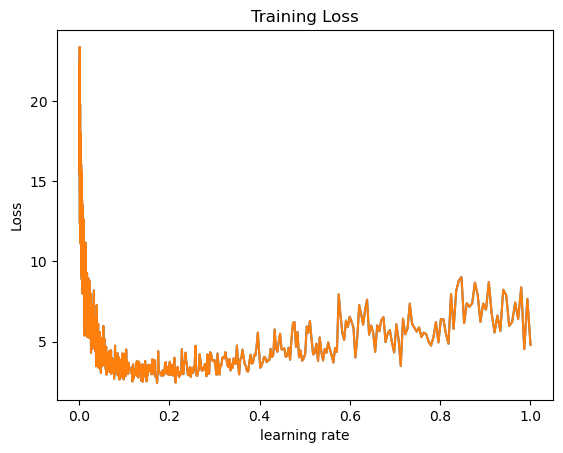

In [117]:
plt.plot(lri, lossi)  #
plt.title('Training Loss')
plt.xlabel('learning rate')
plt.ylabel('Loss')
plt.show()

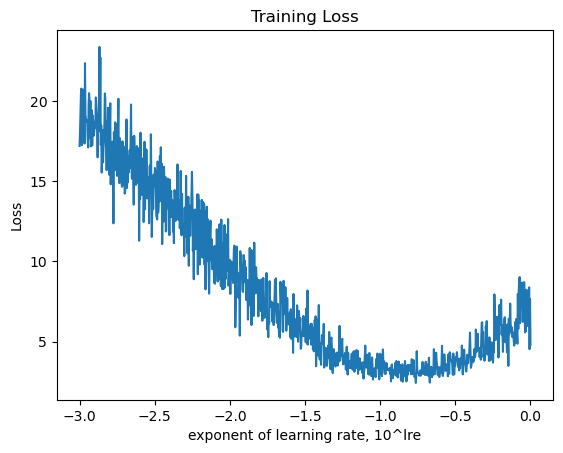

In [118]:
plt.plot(lrei, lossi) 
plt.title('Training Loss')
plt.xlabel('exponent of learning rate, 10^lre')
plt.ylabel('Loss')
plt.show()

In [ ]:
#
# traing-valuation-test splits
#

In [138]:
# build the dataset

def build_dataset(words):  
    block_size = 3 # context length: how many characters do we take to predict the next one?
    X, Y = [], []
    for w in words:

        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [121]:
len(words)

32033

In [122]:
n1, n2-n1, len(words)-n2

(25626, 3203, 3204)

In [123]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182580, 3]), torch.Size([182580]))

In [124]:
g = torch.Generator().manual_seed(2147483647)     # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [126]:
sum(p.nelement() for p in parameters)

3481

In [127]:
for p in parameters:
    p.requires_grad = True

In [133]:
lre = torch.linspace(-3, 0, 1000)  # similar to range()
lrs = 10**lre

In [134]:
lri = []
lossi = []

for i in range(10000):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32, ))
    
    # forward pass
    emb = C[Xtr[ix]]                               # (32, 3, 2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)     # (32,100)
    logits = h @ W2 + b2                         # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
#     lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
#     lri.append(lr)
#     lossi.append(loss.item())

print(loss.item())

2.4378557205200195


In [139]:
emb = C[Xtr]                                 # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1)     # (32,100)
logits = h @ W2 + b2                         # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.5736, grad_fn=<NllLossBackward0>)

In [142]:
emb = C[Xval]                                # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1)     # (32,100)
logits = h @ W2 + b2                         # (32, 27)
loss = F.cross_entropy(logits, Yval)
loss

tensor(2.5789, grad_fn=<NllLossBackward0>)

In [143]:
emb = C[Xte]                                # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1)     # (32,100)
logits = h @ W2 + b2                         # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.5727, grad_fn=<NllLossBackward0>)

In [144]:
#
# Larger Hidden Layer
#

In [149]:
g = torch.Generator().manual_seed(2147483647)     # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [150]:
sum(p.nelement() for p in parameters) # number of parameters in total

10281

In [151]:
for p in parameters:
    p.requires_grad = True
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [152]:
lri = []
lossi = []
stepi = []

for i in range(30000):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32, ))
    
    # forward pass
    emb = C[Xtr[ix]]                               # (32, 3, 2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)     # (32,100)
    logits = h @ W2 + b2                         # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
#     lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    #lri.append(lr)
    stepi.append(i)
    lossi.append(loss.item())

print(loss.item())

2.409832000732422


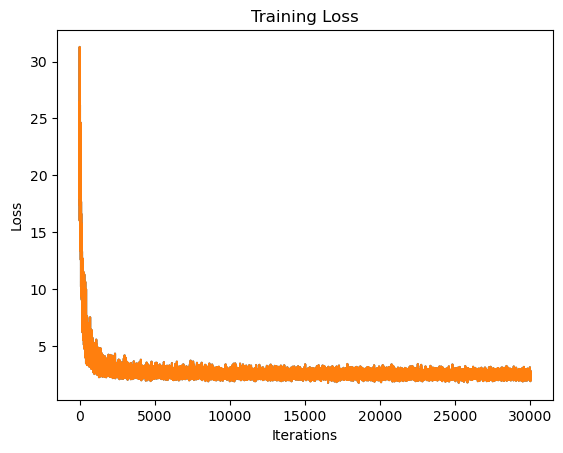

In [154]:
plt.plot(stepi, lossi)
plt.title('Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [155]:
emb = C[Xtr]                                 # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1)     # (32,100)
logits = h @ W2 + b2                         # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.4772, grad_fn=<NllLossBackward0>)

In [156]:
emb = C[Xval]                                # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1)     # (32,100)
logits = h @ W2 + b2                         # (32, 27)
loss = F.cross_entropy(logits, Yval)
loss


tensor(2.4900, grad_fn=<NllLossBackward0>)

In [157]:
emb = C[Xte]                                # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1)     # (32,100)
logits = h @ W2 + b2                         # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss


tensor(2.4796, grad_fn=<NllLossBackward0>)

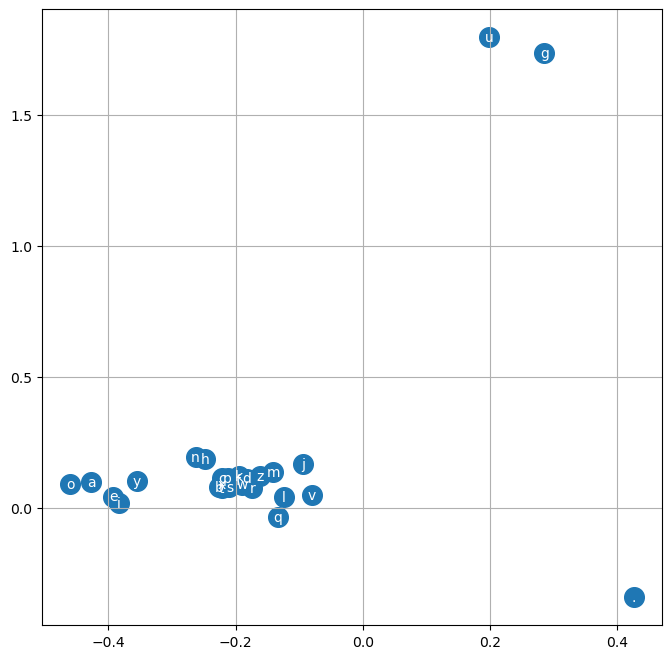

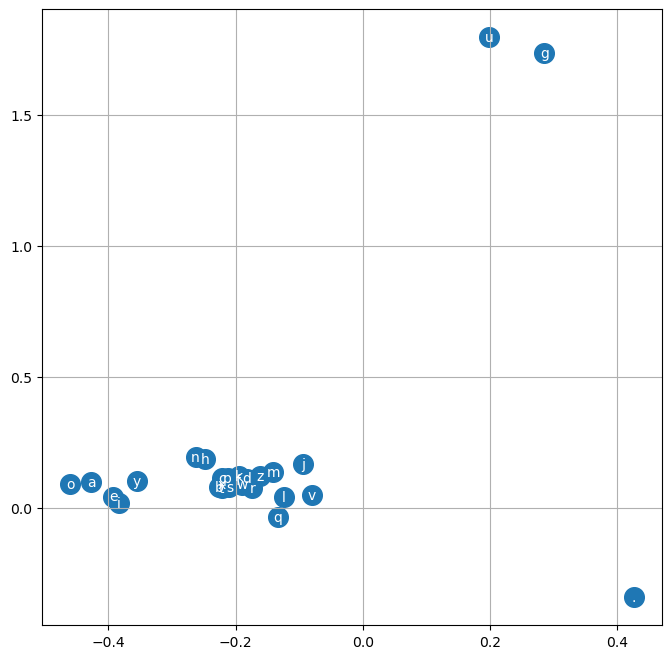

In [159]:
plt.figure(figsize = (8,8))
plt.scatter(C[:,0].data, C[:,1].data, s = 200)

for i in range(C.shape[0]):
    plt.text(C[i,0].item(),C[i,1].item(), itos[i], ha = "center", va = "center", color= "white")
plt.grid('minor')
plt.show()

In [160]:
#
# large embedding size
#

In [161]:
g = torch.Generator().manual_seed(2147483647)     # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [162]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [163]:
for p in parameters:
    p.requires_grad = True
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lri = []
lossi = []
stepi = []

In [164]:
for i in range(50000):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32, ))
    
    # forward pass
    emb = C[Xtr[ix]]                               # (32, 3, 2)
    h = torch.tanh(emb.view(-1,30) @ W1 + b1)     # (32,100)
    logits = h @ W2 + b2                         # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
#     lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    #lri.append(lr)
    stepi.append(i)
    lossi.append(loss.log10().item())

print(loss.item())

2.403036594390869


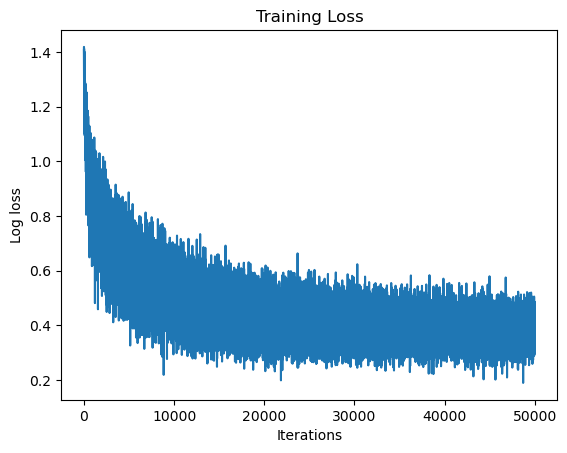

In [165]:
plt.plot(stepi, lossi)
plt.title('Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Log loss')
plt.show()

In [166]:
emb = C[Xtr]                                 # (32, 3, 2)
h = torch.tanh(emb.view(-1,30) @ W1 + b1)    # (32,100)
logits = h @ W2 + b2                         # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.4247, grad_fn=<NllLossBackward0>)

In [167]:
emb = C[Xval]                                 # (32, 3, 2)
h = torch.tanh(emb.view(-1,30) @ W1 + b1)    # (32,100)
logits = h @ W2 + b2                         # (32, 27)
loss = F.cross_entropy(logits, Yval)
loss

tensor(2.4620, grad_fn=<NllLossBackward0>)

In [168]:
emb = C[Xte]                                 # (32, 3, 2)
h = torch.tanh(emb.view(-1,30) @ W1 + b1)    # (32,100)
logits = h @ W2 + b2                         # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss


tensor(2.4482, grad_fn=<NllLossBackward0>)

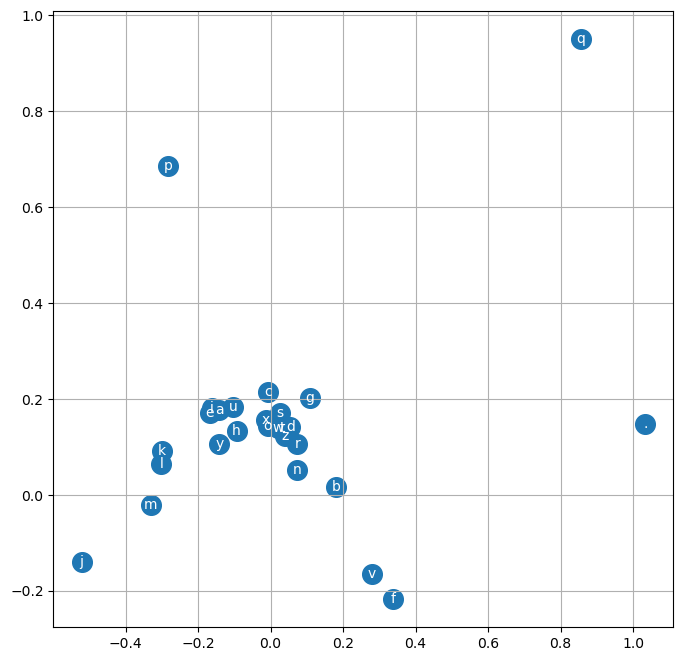

In [169]:
plt.figure(figsize = (8,8))
plt.scatter(C[:,0].data, C[:,1].data, s = 200)

for i in range(C.shape[0]):
    plt.text(C[i,0].item(),C[i,1].item(), itos[i], ha = "center", va = "center", color= "white")
plt.grid('minor')
plt.show()

In [170]:
#
# final version
#

In [171]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182437, 3]), torch.Size([182437]))

In [172]:
g = torch.Generator().manual_seed(2147483647)     # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [173]:
sum(p.nelement() for p in parameters) # number of parameters in total


11897

In [174]:
for p in parameters:
    p.requires_grad = True
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lri = []
lossi = []
stepi = []

In [175]:
for i in range(200000):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32, ))
    
    # forward pass
    emb = C[Xtr[ix]]                               # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)     # (32,100)
    logits = h @ W2 + b2                           # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    #lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    #lri.append(lr)
    stepi.append(i)
    lossi.append(loss.log10().item())

print(loss.item())


2.3040947914123535


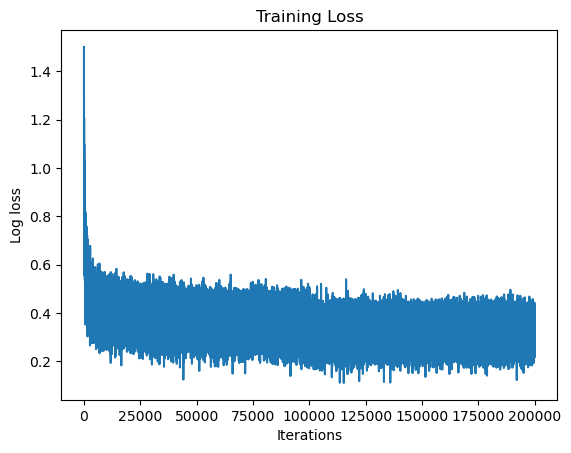

In [176]:
plt.plot(stepi, lossi)
plt.title('Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Log loss')
plt.show()

In [177]:
emb = C[Xtr]                                 # (32, 3, 2)
h = torch.tanh(emb.view(-1,30) @ W1 + b1)    # (32,100)
logits = h @ W2 + b2                         # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1226, grad_fn=<NllLossBackward0>)

In [178]:
emb = C[Xval]                                 # (32, 3, 2)
h = torch.tanh(emb.view(-1,30) @ W1 + b1)    # (32,100)
logits = h @ W2 + b2                         # (32, 27)
loss = F.cross_entropy(logits, Yval)
loss

tensor(2.1859, grad_fn=<NllLossBackward0>)

In [179]:
emb = C[Xte]                                 # (32, 3, 2)
h = torch.tanh(emb.view(-1,30) @ W1 + b1)    # (32,100)
logits = h @ W2 + b2                         # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1757, grad_fn=<NllLossBackward0>)

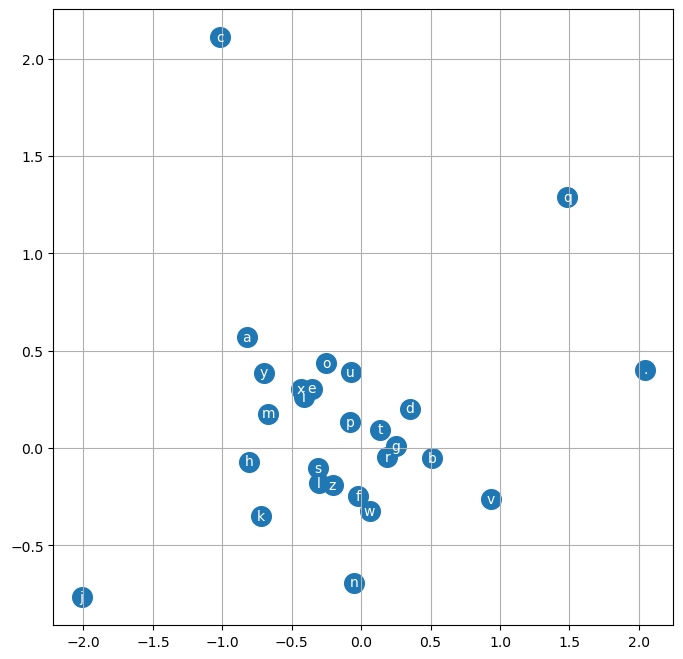

In [180]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize = (8,8))
plt.scatter(C[:,0].data, C[:,1].data, s = 200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(),C[i,1].item(), itos[i], ha = "center", va = "center", color= "white")
plt.grid('minor')
plt.show()